C:\Users\35088\AppData\Local\Temp\ipykernel_210188\325053225.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
C:\Users\35088\AppData\Local\Temp\ipykernel_210188\325053225.py:250: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)
C:\Users\35088\AppData\Local\Temp\ipykernel_210188\325053225.py:272: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=12)
C:\Users\35088\AppData\Local\Temp\ipykernel_210188\325053225.py:290: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels(ax4.get_yticklab

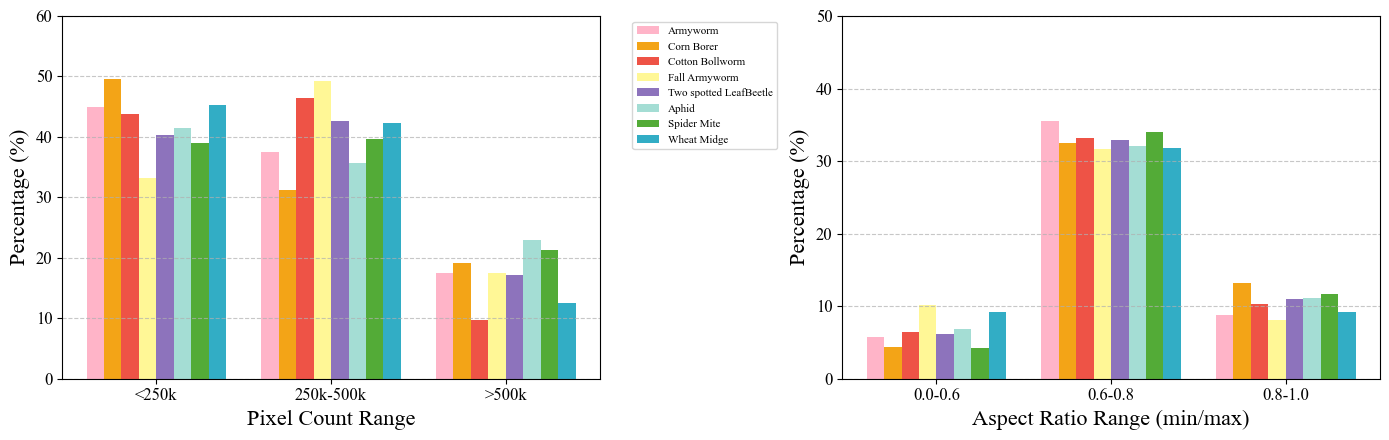

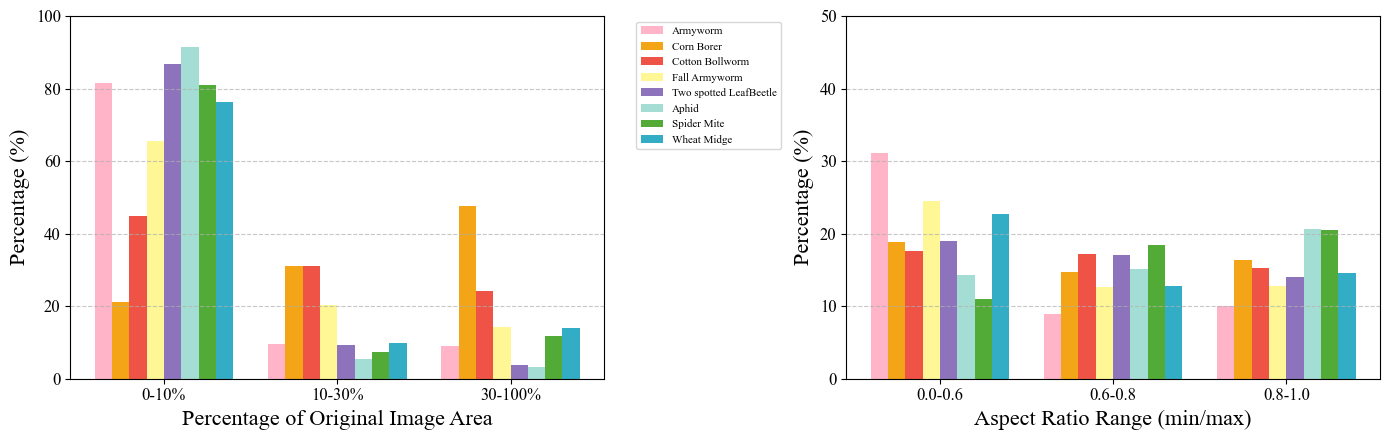

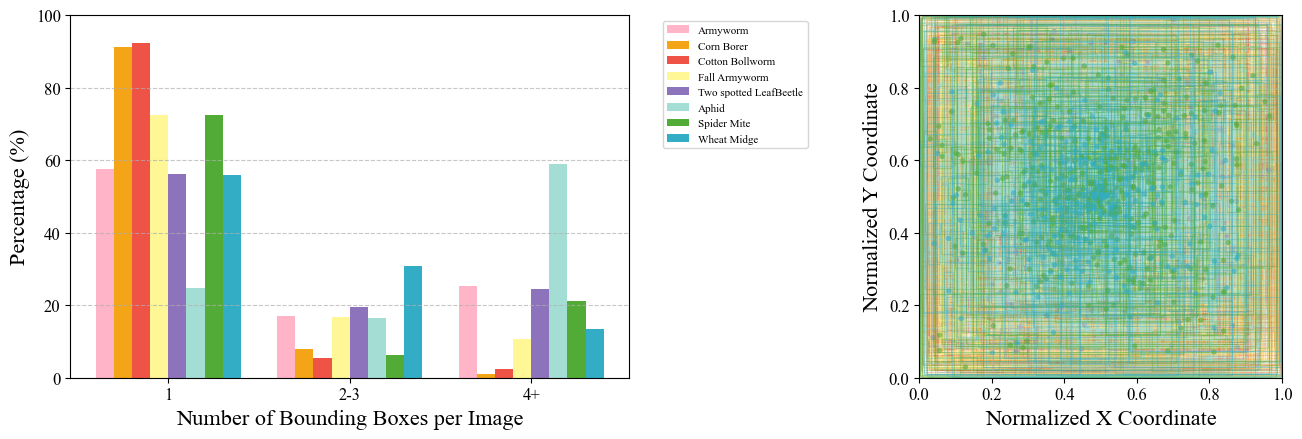

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Rectangle

# 设置英文显示和论文格式风格
plt.style.use('seaborn-v0_8-muted')  # 低饱和度风格
plt.rcParams["font.family"] = ["Times New Roman", "Arial"]
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.titlesize'] = 14

# 自定义颜色 - RGB转换为0-1范围
custom_colors_rgb = [
    (255, 180, 200),
    (243, 164, 23),
    (238, 83, 70),
    (255, 247, 150),
    (141, 115, 188),
    (164, 221, 212),
    (83, 171, 55),
    (50, 173, 197)  
]

# 将RGB值转换为matplotlib所需的0-1范围
custom_colors = [(r/255, g/255, b/255) for r, g, b in custom_colors_rgb]

# 数据目录
base_dir = r"D:\25.10.29backup\25.7.24\pest_text\api\data_processed\merge"

# 存储所有数据
class_names = [
    'Armyworm',
    'Corn Borer',
    'Cotton Bollworm',
    'Fall Armyworm',
    'Two spotted LeafBeetle',
    'Aphid',
    'Spider Mite',
    'Wheat Midge']
image_data = []
bbox_data = []
class_counts = defaultdict(int)
image_bbox_counts = defaultdict(lambda: defaultdict(int))  # 记录每张图片的检测框数量

# 遍历所有类别文件夹
for index, class_folder in enumerate(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    class_name = class_names[index]
    
    # 遍历图像文件
    for file in os.listdir(class_path):
        if file.endswith(".jpg"):
            class_counts[class_name] += 1
            
            # 读取图像信息
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            height, width = img.shape[:2]
            pixel_count = width * height
            aspect_ratio = min(width, height) / max(width, height) if min(width, height) > 0 else 0
            
            image_data.append({
                'class': class_name,
                'pixels': pixel_count,
                'aspect_ratio': aspect_ratio,
                'image_name': file
            })
            
            # 读取标注文件并统计检测框数量
            txt_file = os.path.splitext(file)[0] + ".txt"
            txt_path = os.path.join(class_path, txt_file)
            
            bbox_count = 0
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            bbox_count += 1
                            _, x_center, y_center, w, h = map(float, parts[:5])
                            
                            bbox_aspect_ratio = min(w, h) / max(w, h) if min(w, h) > 0 else 0
                            bbox_area_ratio = (w * h) * 100
                            
                            bbox_data.append({
                                'class': class_name,
                                'area_ratio': bbox_area_ratio,
                                'aspect_ratio': bbox_aspect_ratio,
                                'center_x': x_center,
                                'center_y': y_center,
                                'width': w,  # 保存宽度
                                'height': h   # 保存高度
                            })
            
            image_bbox_counts[class_name][file] = bbox_count

# 转换为DataFrame
image_df = pd.DataFrame(image_data)
bbox_df = pd.DataFrame(bbox_data)

# 计算总数用于百分比转换
total_images = len(image_df)
total_bboxes = len(bbox_df)

# ---------------------- 新增：按类别统计各个分布数据 ----------------------
# 1. 图像宽高比分布（按类别）
image_aspect_bins = [0.0, 0.6, 0.8, 1.0]
image_aspect_labels = ['0.0-0.6', '0.6-0.8', '0.8-1.0']
class_image_aspect_percentages = {}

for class_name in class_names:
    class_images = image_df[image_df['class'] == class_name]
    total_class = len(class_images)
    if total_class == 0:
        class_image_aspect_percentages[class_name] = [0]*len(image_aspect_labels)
        continue
    
    counts, _ = np.histogram(class_images['aspect_ratio'], bins=image_aspect_bins)
    # 确保计数与标签数量一致
    if len(counts) != len(image_aspect_labels):
        counts = counts[:len(image_aspect_labels)] if len(counts) > len(image_aspect_labels) else \
                 np.pad(counts, (0, len(image_aspect_labels)-len(counts)), mode='constant')
    
    percentages = (counts / total_class) * 100
    class_image_aspect_percentages[class_name] = percentages

# 2. 检测框面积占比分布（按类别）
bbox_area_bins = [0, 10, 30, 100]
bbox_area_labels = ['0-10%', '10-30%', '30-100%']
class_bbox_area_percentages = {}

for class_name in class_names:
    class_bboxes = bbox_df[bbox_df['class'] == class_name]
    total_class_bboxes = len(class_bboxes)
    if total_class_bboxes == 0:
        class_bbox_area_percentages[class_name] = [0]*len(bbox_area_labels)
        continue
    
    counts, _ = np.histogram(class_bboxes['area_ratio'], bins=bbox_area_bins)
    if len(counts) != len(bbox_area_labels):
        counts = counts[:len(bbox_area_labels)] if len(counts) > len(bbox_area_labels) else \
                 np.pad(counts, (0, len(bbox_area_labels)-len(counts)), mode='constant')
    
    percentages = (counts / total_class_bboxes) * 100
    class_bbox_area_percentages[class_name] = percentages

# 3. 检测框宽高比分布（按类别）
bbox_aspect_bins = [0.0, 0.6, 0.8, 1.0]
bbox_aspect_labels = ['0.0-0.6', '0.6-0.8', '0.8-1.0']
class_bbox_aspect_percentages = {}

for class_name in class_names:
    class_bboxes = bbox_df[bbox_df['class'] == class_name]
    total_class_bboxes = len(class_bboxes)
    if total_class_bboxes == 0:
        class_bbox_aspect_percentages[class_name] = [0]*len(bbox_aspect_labels)
        continue
    
    counts, _ = np.histogram(class_bboxes['aspect_ratio'], bins=bbox_aspect_bins)
    if len(counts) != len(bbox_aspect_labels):
        counts = counts[:len(bbox_aspect_labels)] if len(counts) > len(bbox_aspect_labels) else \
                 np.pad(counts, (0, len(bbox_aspect_labels)-len(counts)), mode='constant')
    
    percentages = (counts / total_class_bboxes) * 100
    class_bbox_aspect_percentages[class_name] = percentages

# 4. 检测框数量分布（按类别，修改区间）
bbox_count_bins = [1, 2, 4, float('inf')]  # 修改为1, 2-3, 4+
bbox_count_labels = ['1', '2-3', '4+']
class_bbox_percentages = {}

for class_name in class_names:
    bbox_counts = list(image_bbox_counts[class_name].values())
    total_images_class = len(bbox_counts)
    if total_images_class == 0:
        class_bbox_percentages[class_name] = [0]*len(bbox_count_labels)
        continue
    
    counts, _ = np.histogram(bbox_counts, bins=bbox_count_bins)
    if len(counts) != len(bbox_count_labels):
        counts = counts[:len(bbox_count_labels)] if len(counts) > len(bbox_count_labels) else \
                 np.pad(counts, (0, len(bbox_count_labels)-len(counts)), mode='constant')
    
    percentages = (counts / total_images_class) * 100
    class_bbox_percentages[class_name] = percentages

# ---------------------- 绘制图表（重点修改：拉大横轴指标间距） ----------------------
bar_width = 0.12  # 保持柱状图宽度不变
index_spacing = 1.2  # 关键参数：指标间的间距（越大越宽），默认1.0，改为2.0翻倍

# 第一个图表：图像属性分析
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # 适当增大图宽以适应间距

# 1. 图像像素数分布（百分比形式）
pixel_bins = [0, 250000, 500000, float('inf')]
pixel_labels = ['<250k', '250k-500k', '>500k']

# 计算每个指标的基准位置（用index_spacing拉开间距）
pixel_base_positions = np.arange(len(pixel_labels)) * index_spacing

for i, class_name in enumerate(class_names):
    class_images = image_df[image_df['class'] == class_name]
    total_class = len(class_images)
    counts, _ = np.histogram(class_images['pixels'], bins=pixel_bins)
    percentages = (counts / total_class) * 100 if total_class > 0 else 0
    
    # 每个类别的柱状图在基准位置上偏移
    ax1.bar(pixel_base_positions + i*bar_width, percentages, width=bar_width, 
            label=class_name, color=custom_colors[i])

# 标题移至下方
# ax1.set_title('(a) Distribution of Image Pixel Counts by Class', y=-0.25)
ax1.set_xlabel('Pixel Count Range',fontsize=16)
ax1.set_ylabel('Percentage (%)',fontsize=16)
# 设置x轴刻度为每个指标的中心位置
ax1.set_xticks(pixel_base_positions + bar_width*3.5)
ax1.set_xticklabels(pixel_labels, rotation=0, fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
ax1.set_ylim(0, 60)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. 图像宽高比分布（修改后，按类别绘制）
aspect_base_positions = np.arange(len(image_aspect_labels)) * index_spacing

for i, class_name in enumerate(class_names):
    percentages = class_image_aspect_percentages[class_name]
    ax2.bar(aspect_base_positions + i*bar_width, percentages, width=bar_width,
            label=class_name, color=custom_colors[i])

# ax2.set_title('(b) Distribution of Image Aspect Ratios', y=-0.25)
ax2.set_xlabel('Aspect Ratio Range (min/max)',fontsize=16)
ax2.set_ylabel('Percentage (%)',fontsize=16)
ax2.set_xticks(aspect_base_positions + bar_width*3.5)
ax2.set_xticklabels(image_aspect_labels, rotation=0,fontsize=12)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # 预留标题空间

# 第二个图表：检测框属性分析
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))

# 3. 检测框面积占比分布（修改后，按类别绘制）
area_base_positions = np.arange(len(bbox_area_labels)) * index_spacing

for i, class_name in enumerate(class_names):
    percentages = class_bbox_area_percentages[class_name]
    ax3.bar(area_base_positions + i*bar_width, percentages, width=bar_width,
            label=class_name, color=custom_colors[i])

# ax3.set_title('(a) Distribution of Bounding Box Area Ratios', y=-0.25)
ax3.set_xlabel('Percentage of Original Image Area',fontsize=16)
ax3.set_ylabel('Percentage (%)',fontsize=16)
ax3.set_xticks(area_base_positions + bar_width*3.5)
ax3.set_xticklabels(bbox_area_labels, rotation=0, fontsize=12)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=12)
ax3.set_ylim(0, 100)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# 4. 检测框宽高比分布（修改后，按类别绘制）
bbox_aspect_base_positions = np.arange(len(bbox_aspect_labels)) * index_spacing

for i, class_name in enumerate(class_names):
    percentages = class_bbox_aspect_percentages[class_name]
    ax4.bar(bbox_aspect_base_positions + i*bar_width, percentages, width=bar_width,
            label=class_name, color=custom_colors[i])

# ax4.set_title('(b) Distribution of Bounding Box Aspect Ratios', y=-0.25)
ax4.set_xlabel('Aspect Ratio Range (min/max)',fontsize=16)
ax4.set_ylabel('Percentage (%)',fontsize=16)
ax4.set_xticks(bbox_aspect_base_positions + bar_width*3.5)
ax4.set_xticklabels(bbox_aspect_labels, rotation=0,fontsize=12)
ax4.set_yticklabels(ax4.get_yticklabels(), fontsize=12)
ax4.set_ylim(0, 100)
ax4.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# 第三个图表：检测框数量和位置分布
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 5))

# 5. 检测框数量分布（修改后，按类别绘制）
count_base_positions = np.arange(len(bbox_count_labels)) * index_spacing

for i, class_name in enumerate(class_names):
    percentages = class_bbox_percentages[class_name]
    ax5.bar(count_base_positions + i*bar_width, percentages, 
            width=bar_width, label=class_name, color=custom_colors[i])

# ax5.set_title('(a) Distribution of Bounding Boxes per Image', y=-0.25)
ax5.set_xlabel('Number of Bounding Boxes per Image', fontsize=16)
ax5.set_ylabel('Percentage (%)', fontsize=16)
ax5.set_xticks(count_base_positions + bar_width*3.5)
ax5.set_xticklabels(bbox_count_labels, fontsize=12)
ax5.set_yticklabels(ax5.get_yticklabels(), fontsize=12)
ax5.set_ylim(0, 100)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(axis='y', linestyle='--', alpha=0.7)

# ---------------------- 重点修改：6. 检测框中心点位置分布（添加完整检测框） ----------------------
# 创建一个虚拟的"画布"，大小为1x1（归一化坐标）
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)

# 为每个类别绘制检测框和中心点
for i, class_name in enumerate(class_names):
    class_bboxes = bbox_df[bbox_df['class'] == class_name]
    if len(class_bboxes) == 0:
        continue
    
    # 获取当前类别的所有检测框数据
    center_x = class_bboxes['center_x'].values
    center_y = class_bboxes['center_y'].values
    width = class_bboxes['width'].values
    height = class_bboxes['height'].values
    
    # 绘制检测框（半透明）
    for x, y, w, h in zip(center_x, center_y, width, height):
        # 计算检测框的左下角坐标（归一化）
        x_left = x - w / 2
        y_bottom = y - h / 2  # 注意：matplotlib的y轴向上，与图像坐标系一致
        
        # 创建矩形框
        rect = Rectangle((x_left, y_bottom), w, h, 
                       linewidth=0.8, 
                       edgecolor=custom_colors[i],
                       facecolor='none',
                       alpha=0.3)  # 边框半透明
        ax6.add_patch(rect)
    
    # 绘制中心点（实心点）
    ax6.scatter(center_x, center_y, 
                alpha=0.6,  # 点半透明
                label=class_name, 
                s=15,  # 点的大小
                edgecolors='none', 
                color=custom_colors[i])

# 设置图表属性
ax6.set_xlabel('Normalized X Coordinate', fontsize=16)
ax6.set_ylabel('Normalized Y Coordinate', fontsize=16)
ax6.set_xticklabels(ax6.get_xticklabels(), fontsize=12)
ax6.set_yticklabels(ax6.get_yticklabels(), fontsize=12)

# 添加网格线（更细的虚线）
ax6.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

# 添加图例（放在右上角，避免遮挡）
# ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 保持坐标轴比例一致
ax6.set_aspect('equal')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# 显示所有图表
plt.show()

In [2]:
# fig1.savefig('fig1_image_properties.svg', bbox_inches='tight', format='svg')
# fig2.savefig('fig2_bbox_properties.svg', bbox_inches='tight', format='svg')
# fig3.savefig('fig3_bbox_counts_positions.svg', bbox_inches='tight', format='svg')

fig1.savefig('fig1_image_properties.pdf', bbox_inches='tight')
fig2.savefig('fig2_bbox_properties.pdf', bbox_inches='tight')
fig3.savefig('fig3_bbox_counts_positions.pdf', bbox_inches='tight')